In [1]:
import sys
%pylab inline
from __future__ import print_function
import pykalman as pk

start_ind = 0
F = np.eye(4)
delta_t = 0.1
F[0,2] = delta_t
F[1,3] = delta_t
Q = 0.001*np.eye(4)
R = np.array([1,0,0,50]).reshape(2,2)
B = np.array([0, -0.5*delta_t**2,0,-delta_t]).reshape(4,1)
u = 9.8
H = np.array([1,0,0,0,0,1,0,0]).reshape(2,4)
dot_size = 10 #for plotting
custom_figsize = (10,6)
print('F:\n{}\nB:\n{}\nu:\n{}\nQ:\n{}\nR:\n{}\nH:\n{}\n'.format(F,B,u,Q,R,H))

Populating the interactive namespace from numpy and matplotlib
F:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
B:
[[ 0.   ]
 [-0.005]
 [ 0.   ]
 [-0.1  ]]
u:
9.8
Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]
R:
[[ 1  0]
 [ 0 50]]
H:
[[1 0 0 0]
 [0 1 0 0]]



The model is:
$$
X_k = FX_{k-1} + B\mu + w_k, \text{where $w_k \sim \mathcal{N}(0,Q)$} \\
Y_k = HX_{k} + v_k, \text{where $v_k \sim \mathcal{N}(0,R)$}
$$

In [63]:
def mse(v1,v2):
    return np.mean(np.sum((v1-v2)**2,axis=0))


def generate_trajectory(T, starting_point):
    X = np.array(starting_point).reshape(4,1)
    Y = np.array(starting_point[:2]).reshape(2,1)

    xs = np.empty((4,T))
    for i in range(T):
        xs[:,i, None] = np.array(X)
        w = np.random.multivariate_normal(np.zeros(4), Q, 1).reshape(4,1)
        X = np.dot(F,X) + np.dot(B,u) + w

    err = np.random.multivariate_normal(np.zeros(2), R, T).T
    ys = np.dot(H,xs) + err
    return xs,ys
    
def kalman_filter(ys, starting_point, Q, R, starting_cov=np.zeros((4,4))):
    kalman_xs = np.zeros((4,T),dtype=np.float64)
    kalman_xs[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_xs_filtered = np.zeros((4,T),dtype=np.float64)
    kalman_xs_filtered[:,0] = np.array(starting_point,dtype=np.float64)
    kalman_covs = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs_filtered = np.zeros((4,4,T),dtype=np.float64)
    kalman_covs[:,:,0] = starting_cov
    kalman_covs_filtered[:,:,0] = np.zeros_like(Q)
    kalman_s = np.zeros((2,2),dtype=np.float64)
    kalman_k = np.zeros((4,2),dtype=np.float64)
    kalman_y = np.zeros((2,1),dtype=np.float64)
    
    kalman_x = np.array(kalman_xs[:,0]).reshape(4,1)
    kalman_cov = np.array(kalman_covs[:,:,0])

    for i in range(1,T):
        #prediction step
        kalman_x = np.dot(F,kalman_x) + np.dot(B,u)
        kalman_cov = np.dot(np.dot(F,kalman_cov),F.T) + Q
        
        #update #in our notation X_{i|i-1}
        kalman_xs[:,i, None] = np.array(kalman_x)
        kalman_covs[:,:,i] = np.array(kalman_cov)
        
        #filtering step
        kalman_y = ys[:,i, None] - np.dot(H, kalman_x)
        kalman_s = R + np.dot(np.dot(H,kalman_cov),H.T)
        kalman_k = np.dot(np.dot(kalman_cov, H.T), numpy.linalg.inv(kalman_s))
        kalman_x += np.dot(kalman_k, kalman_y)
        kalman_cov -= np.dot(np.dot(kalman_k, H), kalman_cov)
        # in our notation X{i|i}
        kalman_covs_filtered[:,:,i] = np.array(kalman_cov)
        kalman_xs_filtered[:,i,None] = np.array(kalman_x)
        
    return kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered
    
def rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered):
    rts_l = np.zeros((4,4),dtype=np.float64)
    rts_x = np.array(kalman_xs_filtered[:,T-1,None])
    rts_cov = kalman_covs_filtered[:,:,T-1]
    rts_xs = np.zeros_like(kalman_xs, dtype=np.float64)
    rts_ls = np.zeros_like(kalman_covs, dtype=np.float64)
    rts_covs = np.zeros_like(kalman_covs, dtype=np.float64)
    rts_xs[:,T-1,None] = np.array(rts_x)
    rts_covs[:,:,T-1] = np.array(rts_cov)
    

    for i in range(T-2,-1,-1):
        cov_filtered = kalman_covs_filtered[:,:,i]
        cov = kalman_covs[:,:,i+1]
        rts_l = np.dot(cov_filtered, np.dot(F.T, numpy.linalg.inv(cov)))
        rts_x = kalman_xs_filtered[:,i,None] + np.dot(rts_l, rts_x - kalman_xs[:,i+1,None])
        rts_cov = cov_filtered + np.dot(rts_l, np.dot(rts_cov - cov, rts_l.T))
        
        #update - we need it for EM
        rts_xs[:,i,None] = np.array(rts_x)
        rts_covs[:,:,i] = np.array(rts_cov)
        rts_ls[:,:,i] = np.array(rts_l)
        
    return rts_xs, rts_covs, rts_ls
    
def em_algorithm(ys, starting_point, max_steps, starting_cov=np.zeros((4,4))):

    Q = np.eye(4)
    R = np.eye(2)
    R[1,1] = 40
    Qs = np.zeros((4,4,max_steps+1))
    Rs = np.zeros((2,2,max_steps+1))
    Qs[:,:,0] = np.array(Q)
    Rs[:,:,0] = np.array(R)
    steps = 0
    while steps < max_steps-1: 
        kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, starting_point, Q, R, starting_cov=starting_cov)
        rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)
        old_rts_xs = np.array(rts_xs)
        rts_xs = rts_xs.reshape(4,1,T)
        kalman_xs = kalman_xs.reshape(4,1,T)
        kalman_xs_filtered = kalman_xs_filtered.reshape(4,1,T)
        new_ys = np.array(ys.reshape(2,1,T))
        
        #formula from slides but not including B
        # E(x_k | Y_{1:T})
        expected_xs = rts_xs
        # E(x_kx_k^t| Y_{1:t})
        expected_dot = np.einsum('ijk,ljk->ilk', rts_xs, rts_xs) + rts_covs
        # E(x_kx_{k+1}^T| Y_{1:T})
        #tmp = np.einsum('ijk,jlk->ilk', rts_ls[:,:,:T-1], np.einsum('ijk,ljk->ilk', (rts_xs[:,:,1:] - kalman_xs[:,:,1:]), rts_xs[:,:,1:]) + rts_covs[:,:,1:])
        #expected_dot_shift = np.einsum('ijk,ljk->ilk', kalman_xs_filtered[:,:,:T-1], rts_xs[:,:,1:]) +  tmp
        #tmp1 = np.dot(F, expected_dot_shift.sum(axis=2))
        #Q1 = 1.0/(T-1) * (expected_dot[:,:,1:].sum(axis=2) + np.dot(F, np.dot(expected_dot[:,:,:T-1].sum(axis=2),F.T)) - tmp1 - tmp1.T)
        
        
        
        # Q - other formula
        tmp0 = (old_rts_xs[:,1:] - np.dot(F, old_rts_xs[:,:T-1]) - np.dot(B,u)).reshape(4,1,T-1)
        tmp1 = np.einsum('ijk,ljk->il', tmp0, tmp0)
        tmp2 = np.dot(F,np.einsum('ijk,jlk->il', rts_ls[:,:,:T-1], rts_covs[:,:,1:]))
        tmp3 = np.dot(F,np.dot(rts_covs[:,:,:T-1].sum(axis=2),F.T)) + rts_covs[:,:,1:].sum(axis=2)
        Q = 1.0/(T-1) * (tmp1 - tmp2 - tmp2.T + tmp3)
        #print('Diff:',np.sum(np.abs(Q-Q1))) - difference between Q and Q1 is constant
        
        # R - formula from slides
        dot_y1 = np.einsum('ijk,ljk->il', new_ys, new_ys)
        dot_y2 = np.dot(np.einsum('ijk,ljk->il', new_ys, expected_xs),H.T)
        R = 1.0/T *(dot_y1 + np.dot(H, np.dot(expected_dot.sum(axis=2), H.T)) - dot_y2 - dot_y2.T)
        steps+=1
        Qs[:,:,steps] = np.array(Q)
        Rs[:,:,steps] = np.array(R)


    return Qs[:,:,:steps],Rs[:,:,:steps]


def print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, start_ind=0, every_point=1, plot_results=True):
    err_kal = np.sum((xs[:2,:]-kalman_xs[:2,:])**2,axis=0)
    err_y = np.sum((xs[:2,:]-ys)**2,axis=0)
    err_rts = np.sum((xs[:2,:]-rts_xs[:2,:])**2,axis=0)
    print('Mean squared error for real and observed: {}'.format(mse(xs[:2,start_ind:],ys[:,start_ind:])))
    print('Mean squared error for real and kalman: {}'.format(mse(xs[:2,start_ind:], kalman_xs[:2,start_ind:])))
    print('Mean squared error for real and rts: {}'.format(mse(xs[:2,start_ind:], rts_xs[:2,start_ind:])))
    if plot_results:
        figure(1, figsize=custom_figsize)
        title('Trajectories')
        scatter(xs[0,start_ind::every_point],xs[1,start_ind::every_point],c='r',s=dot_size, label='True values')
        scatter(ys[0,start_ind::every_point],ys[1,start_ind::every_point],c='b',s=dot_size, label='Observed values')
        scatter(kalman_xs[0,start_ind::every_point], kalman_xs[1,start_ind::every_point], c='g', s=dot_size, label='Values from kalman filter')
        scatter(rts_xs[0,start_ind::every_point], rts_xs[1,start_ind::every_point], c='y', s=dot_size, label='Values from RTS')
        legend()

        figure(2, figsize=custom_figsize)
        title('Errors')
        plot(np.arange(start_ind,T), err_kal[start_ind:], label = 'Squared error for kalman filter')
        plot(np.arange(start_ind,T), err_y[start_ind:], label = 'Squared error for observed values')
        plot(np.arange(start_ind,T), err_rts[start_ind:], label = 'Squared error for RTS')
        xlabel('Iteration')
        legend()
        show()
        
def run_filtering(xs, ys, Q, R, starting_point, starting_cov=np.zeros((4,4))):
    #kalman filter
    kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered = kalman_filter(ys, starting_point, Q, R, starting_cov)
    #smoothing
    rts_xs, rts_covs, rts_ls = rts_smoothing(ys, kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered)
    return kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls

def print_em_results(Qs, Rs):
    Q_estimated = Qs[:,:,-1]
    R_estimated = Rs[:,:,-1]
    print('True Q:\n{}\n\nQ from EM:\n{}\n\nQ calculated by pykalman library:\n{}\n'.format(Q, Q_estimated, kf.transition_covariance))
    print('True R:\n{}\n\nR from EM:\n{}\n\nR calculated by pykalman library:\n{}\n'.format(R, R_estimated, kf.observation_covariance))
    err_q = ((Qs - Q[:,:,np.newaxis])**2).mean(axis=(0,1))
    err_r = ((Rs - R[:,:,np.newaxis])**2).mean(axis=(0,1)) 
    print('The errors for our EM. Q : {}, R : {}'.format(err_q[-1], err_r[-1]))
    print('The errors for pykalman EM. Q : {}, R : {}'.format(((Q-kf.transition_covariance)**2).mean(axis=(0,1)), ((R-kf.observation_covariance)**2).mean(axis=(0,1))))


    plt.figure(1, figsize=custom_figsize)
    plt.title('Errors for Q')
    plt.plot(np.arange(Qs.shape[2]), err_q, label = 'Mean squared error for Q')
    plt.legend()
    plt.figure(2, figsize=custom_figsize)
    plt.title('Errors for R')
    plt.plot(np.arange(Qs.shape[2]), err_r, label = 'Mean squared error for R')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

We perform simulations for $T=100,1000$ and known starting point vs random starting point for kalman filering
Moreover, we try to estimate $Q$ and $R$ matrices using EM algorithm and check the results again when using the estimators instead of true values.

Results for known starting point
Mean squared error for real and observed: 36.8023431959
Mean squared error for real and kalman: 2.23470747711
Mean squared error for real and rts: 1.30212899396


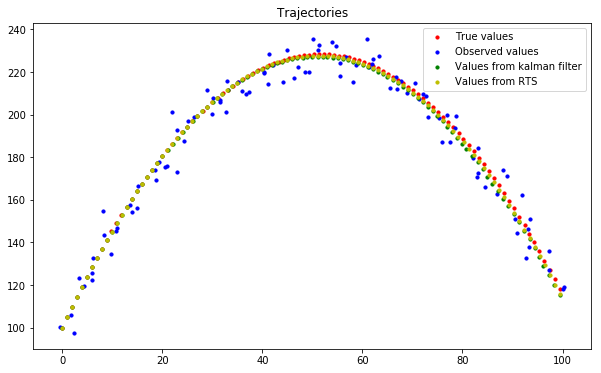

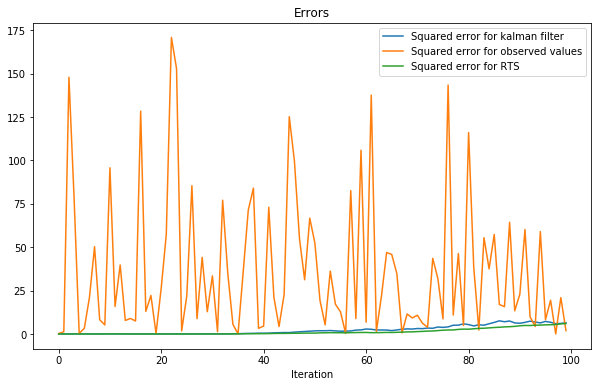

--------------------------------------------------
Results for random starting point
Mean squared error for real and observed: 58.2913576181
Mean squared error for real and kalman: 12.0024096717
Mean squared error for real and rts: 1.93318998443


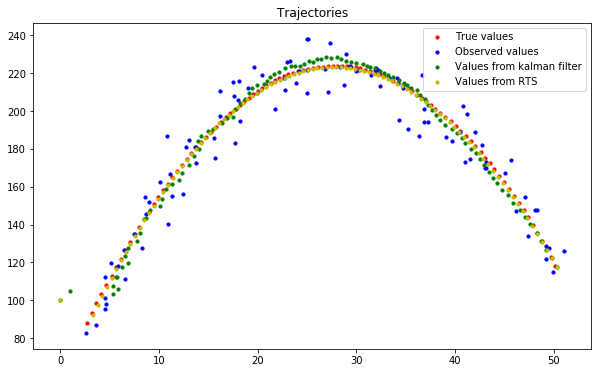

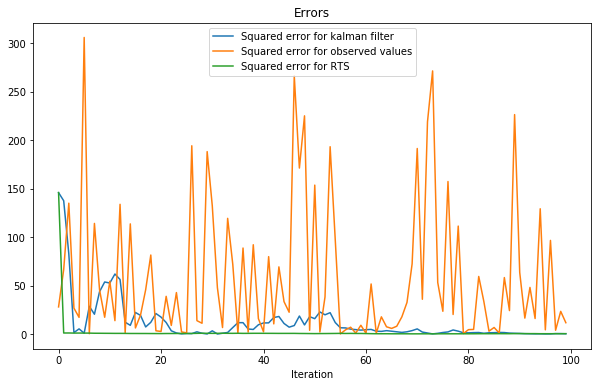

In [86]:
T = 100
starting_point = np.array([0,100, 10, 50]) 
cov_zero = np.zeros((4,4))
cov_nonzero = np.diag(starting_point) + 10*np.eye(4)
start_known = np.random.multivariate_normal(starting_point, cov_zero)
start_random = np.random.multivariate_normal(starting_point, cov_nonzero)

xs,ys = generate_trajectory(T,start_known)
result = run_filtering(xs, ys, Q, R, starting_point=starting_point, starting_cov=cov_zero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('Results for known starting point')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs)

xs,ys = generate_trajectory(T,start_random)
result = run_filtering(xs, ys, Q, R, starting_point=starting_point, starting_cov=cov_nonzero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('-'*50)
print('Results for random starting point')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs)

True Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]

Q from EM:
[[ 0.05516099  0.01710357 -0.00129943 -0.00392918]
 [ 0.01710404  1.24545095  0.01059234 -0.1101072 ]
 [-0.00129943  0.01059032  0.13824011  0.00685127]
 [-0.00392513 -0.11011007  0.0069118   0.52758757]]

Q calculated by pykalman library:
[[ 5.14282770e-02  1.62913111e-02 -1.46244358e-03 -3.03467958e-03]
 [ 1.62075361e-02  1.17855599e+00  9.02131969e-03 -1.07932506e-01]
 [-1.46136032e-03  9.36570323e-03  1.26437903e-01  1.10004988e-02]
 [-3.74472246e-03 -1.07385274e-01  4.88406105e-04  5.08618165e-01]]

True R:
[[ 1  0]
 [ 0 50]]

R from EM:
[[ 0.93915816  0.29199379]
 [ 0.29199395 49.75116941]]

R calculated by pykalman library:
[[ 0.94108691  0.2929742 ]
 [ 0.29294471 49.77375579]]

The errors for our EM. Q : 0.1170566939, R : 0.0590348077428
The errors for pykalman EM. Q : 0.105413684804, R : 0.056576919369


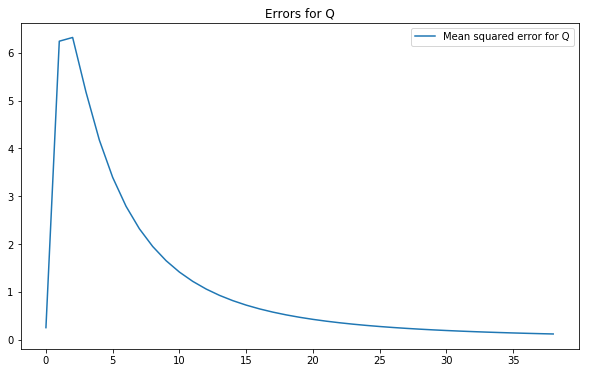

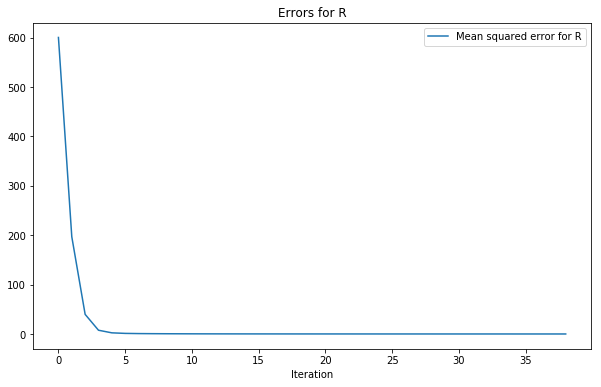

In [27]:
iterations = 40
xs,ys = generate_trajectory(T,start_known)
kf = pk.KalmanFilter(transition_matrices=F, observation_matrices=H, transition_offsets=np.dot(B,u).ravel(), initial_state_mean=starting_point, initial_state_covariance=cov_zero, em_vars=['transition_covariance', 'observation_covariance'])
kf.em(ys.transpose(1,0), n_iter=iterations)
Qs,Rs = em_algorithm(ys, starting_point, iterations)
Q_estimated = Qs[:,:,-1]
R_estimated = Rs[:,:,-1]
print_em_results(Qs, Rs)

Here for a moment we change the initalization of R in EM for $[[1,0],[0,40]]$

True Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]

Q from EM:
[[ 0.12866165  0.07398698 -0.01373464 -0.02806761]
 [ 0.07399124  0.6120244   0.01428465 -0.11725413]
 [-0.01373469  0.01426394  0.26558657  0.02208794]
 [-0.0280607  -0.11722582  0.02217606  0.49463442]]

Q calculated by pykalman library:
[[ 0.14012549  0.33826603 -0.01051277 -0.05099747]
 [ 0.33826911  3.16858428  0.02905988 -0.42581881]
 [-0.01051205  0.02905393  0.23827267  0.03594466]
 [-0.05098116 -0.42594547  0.03600108  0.72365737]]

True R:
[[ 1  0]
 [ 0 50]]

R from EM:
[[ 1.46690502  0.11751779]
 [ 0.11751944 51.35414271]]

R calculated by pykalman library:
[[ 1.44042463 -0.19820955]
 [-0.19820828 48.34924907]]

The errors for our EM. Q : 0.0465692592536, R : 0.519831007557
The errors for pykalman EM. Q : 0.702048543237, R : 0.749381507308


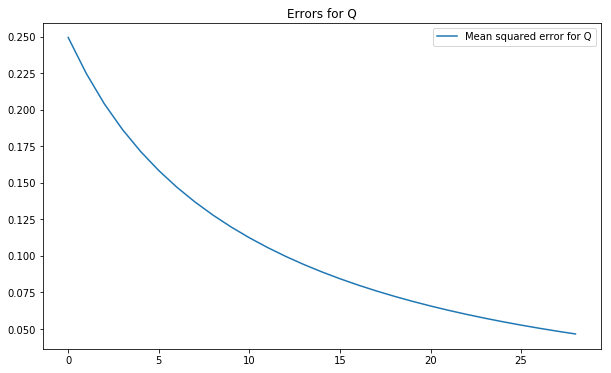

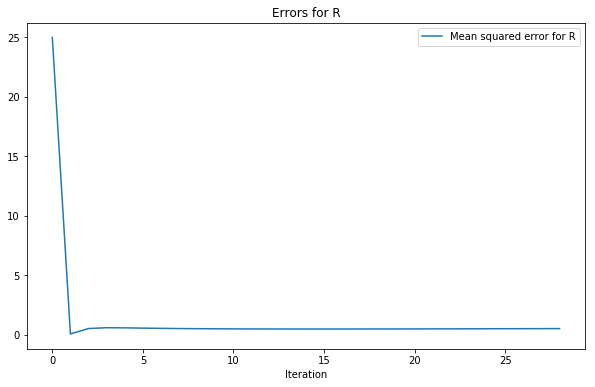

In [66]:
iterations = 30
xs,ys = generate_trajectory(T,start_known)
kf = pk.KalmanFilter(transition_matrices=F, observation_matrices=H, transition_offsets=np.dot(B,u).ravel(), initial_state_mean=starting_point, initial_state_covariance=cov_zero, em_vars=['transition_covariance', 'observation_covariance'])
kf.em(ys.transpose(1,0), n_iter=iterations)
Qs,Rs = em_algorithm(ys, starting_point, iterations)
Q_estimated = Qs[:,:,-1]
R_estimated = Rs[:,:,-1]
print_em_results(Qs, Rs)

Results for known starting point after EM
Mean squared error for real and observed: 55.1666069794
Mean squared error for real and kalman: 10.1449484879
Mean squared error for real and rts: 4.76873005802


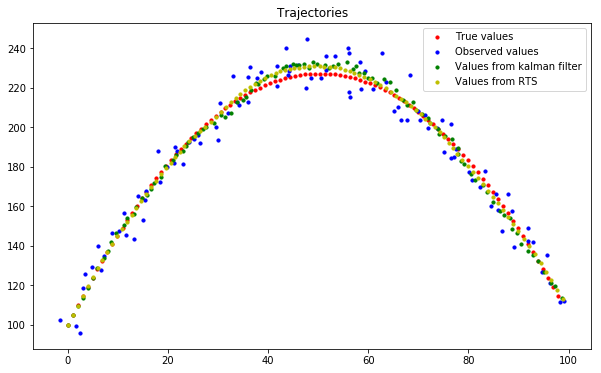

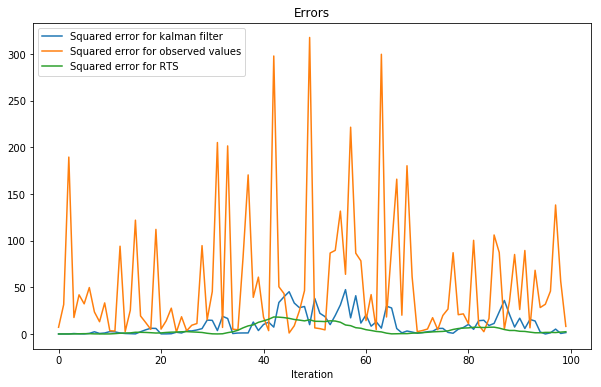

In [30]:
result = run_filtering(xs, ys, Q_estimated, R_estimated, starting_point=starting_point, starting_cov=cov_zero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('Results for known starting point after EM')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs)

Now $T=1000$ - here plots are useless

In [81]:
T = 1000
starting_point = np.array([0,100, 10, 50]) 
cov_zero = np.zeros((4,4))
cov_nonzero = np.diag(starting_point**2)
start_known = np.random.multivariate_normal(starting_point, cov_zero)
start_random = np.random.multivariate_normal(starting_point, cov_nonzero)

xs,ys = generate_trajectory(T,start_known)
result = run_filtering(xs, ys, Q, R, starting_point=starting_point, starting_cov=cov_zero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('Results for known starting point')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, plot_results=False)

xs,ys = generate_trajectory(T,start_random)
result = run_filtering(xs, ys, Q, R, starting_point=starting_point, starting_cov=cov_nonzero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('-'*50)
print('Results for random starting point')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, plot_results=False)

Results for known starting point
Mean squared error for real and observed: 50.6961879698
Mean squared error for real and kalman: 0.81405861847
Mean squared error for real and rts: 0.342726706176
--------------------------------------------------
Results for random starting point
Mean squared error for real and observed: 46.3118699795
Mean squared error for real and kalman: 13.4119053342
Mean squared error for real and rts: 5.83313914154


True Q:
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]

Q from EM:
[[ 4.81212818e-02 -3.82854720e-03  3.88888303e-03  5.05081385e-04]
 [-3.82693360e-03  1.31850036e+00 -2.40503209e-03 -1.58472227e-02]
 [ 3.88879174e-03 -2.39310187e-03  9.35489688e-02 -2.38174178e-03]
 [ 4.77033409e-04 -1.58464380e-02 -3.01875732e-03  4.37165022e-01]]

Q calculated by pykalman library:
[[ 0.04933546 -0.00878507  0.02021993 -0.23224795]
 [ 0.05015567  1.42547316  0.40137175  0.77935876]
 [ 0.01521211  0.10089208  0.14034866 -1.36602967]
 [-0.01752764  0.41505608  1.81755774  2.46685685]]

True R:
[[ 1  0]
 [ 0 50]]

R from EM:
[[ 0.93591457  0.22032091]
 [ 0.22032263 50.72283789]]

R calculated by pykalman library:
[[ 0.94088772  0.22644642]
 [ 0.24328122 51.09645108]]

The errors for our EM. Q : 0.12108883829, R : 0.15592123084
The errors for pykalman EM. Q : 0.89433192645, R : 0.329040743368


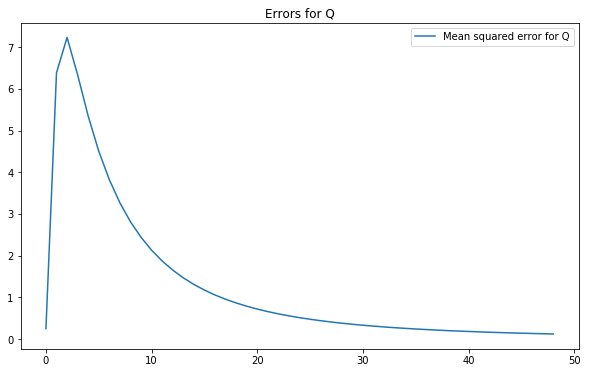

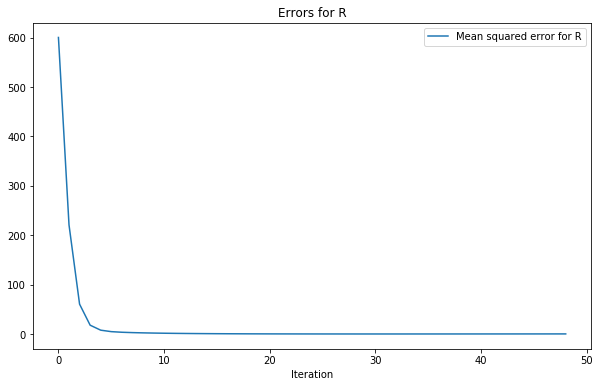

In [47]:
iterations = 50
xs,ys = generate_trajectory(T,start_known)
kf = pk.KalmanFilter(transition_matrices=F, observation_matrices=H, transition_offsets=np.dot(B,u).ravel(), initial_state_mean=starting_point, initial_state_covariance=cov_zero, em_vars=['transition_covariance', 'observation_covariance'])
kf.em(ys.transpose(1,0), n_iter=iterations)
Qs,Rs = em_algorithm(ys, starting_point, iterations)
Q_estimated = Qs[:,:,-1]
R_estimated = Rs[:,:,-1]
print_em_results(Qs, Rs)

In [90]:
result = run_filtering(xs, ys, Q_estimated, R_estimated, starting_point=starting_point, starting_cov=cov_zero)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('Results for known starting point after EM')
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, plot_results=False)

Results for known starting point after EM
Mean squared error for real and observed: 58.2913576181
Mean squared error for real and kalman: 16.2373043137
Mean squared error for real and rts: 6.97556756105


Very bad starting point

Results for very bad starting point and T=50
Mean squared error for real and observed: 56.068954232
Mean squared error for real and kalman: 1466.30856631
Mean squared error for real and rts: 703.663254378


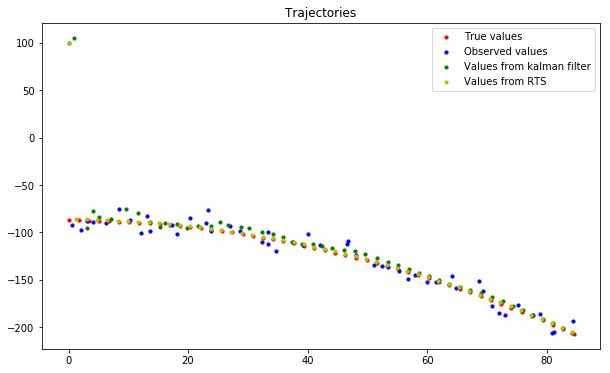

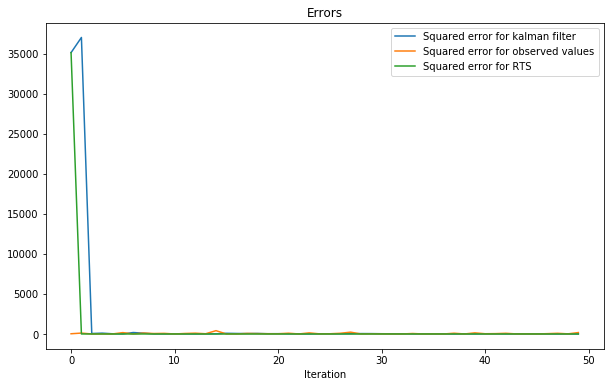

Mean squared error for real and observed: 56.7049533448
Mean squared error for real and kalman: 24.4022855459
Mean squared error for real and rts: 1.49583607397


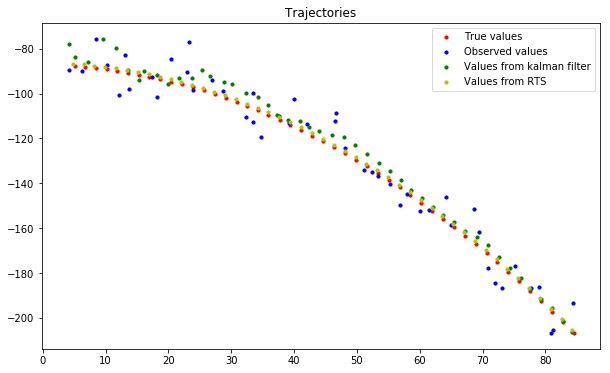

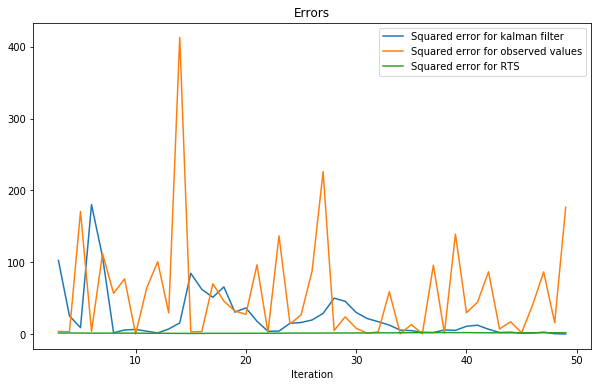

In [62]:
T = 50
starting_point = np.array([0,100, 10, 50]) 
cov_zero = np.zeros((4,4))
cov_big = 10**7*np.eye(4)
start_random = np.random.multivariate_normal(starting_point, cov_nonzero)

xs,ys = generate_trajectory(T,start_random)
result = run_filtering(xs, ys, Q, R, starting_point=starting_point, starting_cov=cov_big)
kalman_xs, kalman_covs, kalman_xs_filtered, kalman_covs_filtered, rts_xs, rts_covs, rts_ls = result
print('Results for very bad starting point and T={}'.format(T))
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, plot_results=True, every_point=1, start_ind=0)
print_kalman_filter_results(xs, ys, kalman_xs, rts_xs, plot_results=True, every_point=1, start_ind=3)